In [1]:
# remove this
import sys
#sys.path.append("/Users/harrison37/Work/alpine/ascent/install-debug/python-modules/")
sys.path.append("/Users/larsen30/research/test_builds/release/ascent/install/python-modules")

In [2]:
# cleanup any old results
!./cleanup.sh

In [3]:
# ascent + conduit imports
import conduit
import conduit.blueprint
import ascent

import numpy as np

# Jupyter imports
from IPython.display import Image
# helper we use when displaying results in the notebook
img_display_width = 500

# Uniform Mesh Example

In [4]:
mesh = conduit.Node()

# create the coordinate set
num_per_dim = 9
mesh["coordsets/coords/type"] = "uniform";
mesh["coordsets/coords/dims/i"] = num_per_dim
mesh["coordsets/coords/dims/j"] = num_per_dim
mesh["coordsets/coords/dims/k"] = num_per_dim

# add origin and spacing to the coordset (optional)
mesh["coordsets/coords/origin/x"] = -10.0
mesh["coordsets/coords/origin/y"] = -10.0
mesh["coordsets/coords/origin/z"] = -10.0

distance_per_step = 20.0/(num_per_dim-1)

mesh["coordsets/coords/spacing/dx"] = distance_per_step
mesh["coordsets/coords/spacing/dy"] = distance_per_step
mesh["coordsets/coords/spacing/dz"] = distance_per_step

# add the topology
# this case is simple b/c it's implicitly derived from the coordinate set
mesh["topologies/topo/type"] = "uniform";
# reference the coordinate set by name
mesh["topologies/topo/coordset"] = "coords";

# create a field
num_vertices = num_per_dim * num_per_dim * num_per_dim
vals = np.zeros(num_vertices,dtype=np.float32)
for i in range(num_vertices):
    if i%2:
        vals[i] = 0.0
    else:
        vals[i] = 1.0
mesh["fields/alternating/association"] = "vertex";
mesh["fields/alternating/topology"] = "topo";
mesh["fields/alternating/values"].set_external(vals)

In [5]:
# print the mesh we created
print(mesh.to_yaml())


coordsets: 
  coords: 
    type: "uniform"
    dims: 
      i: 9
      j: 9
      k: 9
    origin: 
      x: -10.0
      y: -10.0
      z: -10.0
    spacing: 
      dx: 2.5
      dy: 2.5
      dz: 2.5
topologies: 
  topo: 
    type: "uniform"
    coordset: "coords"
fields: 
  alternating: 
    association: "vertex"
    topology: "topo"
    values: [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0

In [6]:
# make sure we conform
verify_info = conduit.Node()
if not conduit.blueprint.mesh.verify(mesh,verify_info):
    print("Mesh Verify failed!")
    print(verify_info)
else:
    print("Mesh verify success!")

Mesh verify success!


In [7]:
# now lets look at the mesh with Ascent
a = ascent.Ascent()

a.open()

# publish mesh to ascent
a.publish(mesh);

# declare a scene to render the dataset
scenes = conduit.Node();
scenes["s1/plots/p1/type"] = "pseudocolor";
scenes["s1/plots/p1/field"] = "alternating";
# Set the output file name (ascent will add ".png")
scenes["s1/image_name"] = "out_ascent_render_uniform";

# setup actions
actions = conduit.Node()
add_act = actions.append();
add_act["action"] = "add_scenes";
add_act["scenes"] = scenes;

# print our full actions tree
print(actions.to_yaml())


# execute
a.execute(actions)

# close ascent
a.close()


- 
  action: "add_scenes"
  scenes: 
    s1: 
      plots: 
        p1: 
          type: "pseudocolor"
          field: "alternating"
      image_name: "out_ascent_render_uniform"



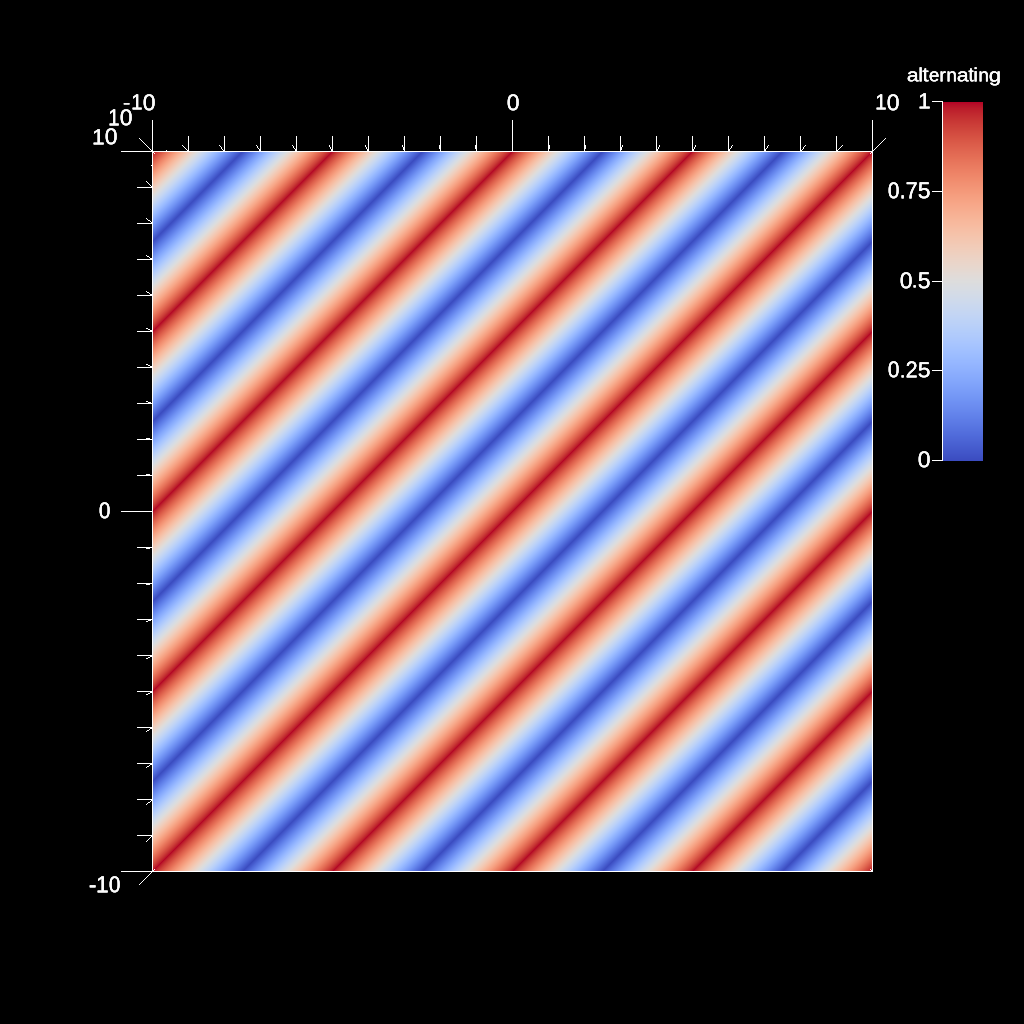

In [8]:
# show the resulting image
Image("out_ascent_render_uniform.png",width=img_display_width)

# Unstructured Example

In [9]:
mesh = conduit.Node()
    # create an explicit coordinate set
x = np.array( [-1.0, 0.0, 0.0, 0.0, 1.0 ], dtype=np.float64 )
y = np.array( [0.0, -1.0, 0.0, 1.0, 0.0 ], dtype=np.float64 )
z = np.array( [ 0.0, 0.0, 1.0, 0.0, 0.0 ], dtype=np.float64 )

mesh["coordsets/coords/type"] = "explicit";
mesh["coordsets/coords/values/x"].set_external(x)
mesh["coordsets/coords/values/y"].set_external(y)
mesh["coordsets/coords/values/z"].set_external(z)

# reference the coordinate set by name
mesh["topologies/mesh/type"] = "unstructured"
mesh["topologies/mesh/coordset"] = "coords"
mesh["topologies/mesh/elements/shape"] = "tet"

connectivity = np.array([0, 1, 3, 2, 4, 3, 1, 2 ],dtype=np.int64)
mesh["topologies/mesh/elements/connectivity"].set_external(connectivity)

num_elements = 2
    
var1 = np.array([0,1],dtype=np.float32)
var2 = np.array([1,0],dtype=np.float32)

mesh["fields/var1/association"] = "element"
mesh["fields/var1/topology"] = "mesh"
mesh["fields/var1/volume_dependent"] = "false"
mesh["fields/var1/values"].set_external(var1)

mesh["fields/var2/association"] = "element"
mesh["fields/var2/topology"] = "mesh"
mesh["fields/var2/volume_dependent"] = "false"
mesh["fields/var2/values"].set_external(var2)

In [10]:
# print the mesh we created
print(mesh.to_yaml())


coordsets: 
  coords: 
    type: "explicit"
    values: 
      x: [-1.0, 0.0, 0.0, 0.0, 1.0]
      y: [0.0, -1.0, 0.0, 1.0, 0.0]
      z: [0.0, 0.0, 1.0, 0.0, 0.0]
topologies: 
  mesh: 
    type: "unstructured"
    coordset: "coords"
    elements: 
      shape: "tet"
      connectivity: [0, 1, 3, 2, 4, 3, 1, 2]
fields: 
  var1: 
    association: "element"
    topology: "mesh"
    volume_dependent: "false"
    values: [0.0, 1.0]
  var2: 
    association: "element"
    topology: "mesh"
    volume_dependent: "false"
    values: [1.0, 0.0]



In [11]:
# make sure we conform
verify_info = conduit.Node()
if not conduit.blueprint.mesh.verify(mesh,verify_info):
    print("Mesh Verify failed!")
    print(verify_info)
else:
    print("Mesh verify success!")

Mesh verify success!


In [14]:
a = ascent.Ascent()
a.open()
# publish mesh to ascent
a.publish(mesh);

scenes = conduit.Node()

# declare a scene to render the dataset
scenes["s1/plots/p1/type"] = "pseudocolor";
scenes["s1/plots/p1/field"] = "var1";
scenes["s1/image_name"] = "out_ascent_render_tet";

#     // setup actions
actions = conduit.Node()
add_act = actions.append()
add_act["action"] = "add_scenes"
add_act["scenes"] = scenes

# print our full actions tree
print(actions.to_yaml())

# execute
a.execute(actions);

# close ascent
a.close()


- 
  action: "add_scenes"
  scenes: 
    s1: 
      plots: 
        p1: 
          type: "pseudocolor"
          field: "var1"
      image_name: "out_ascent_render_tet"



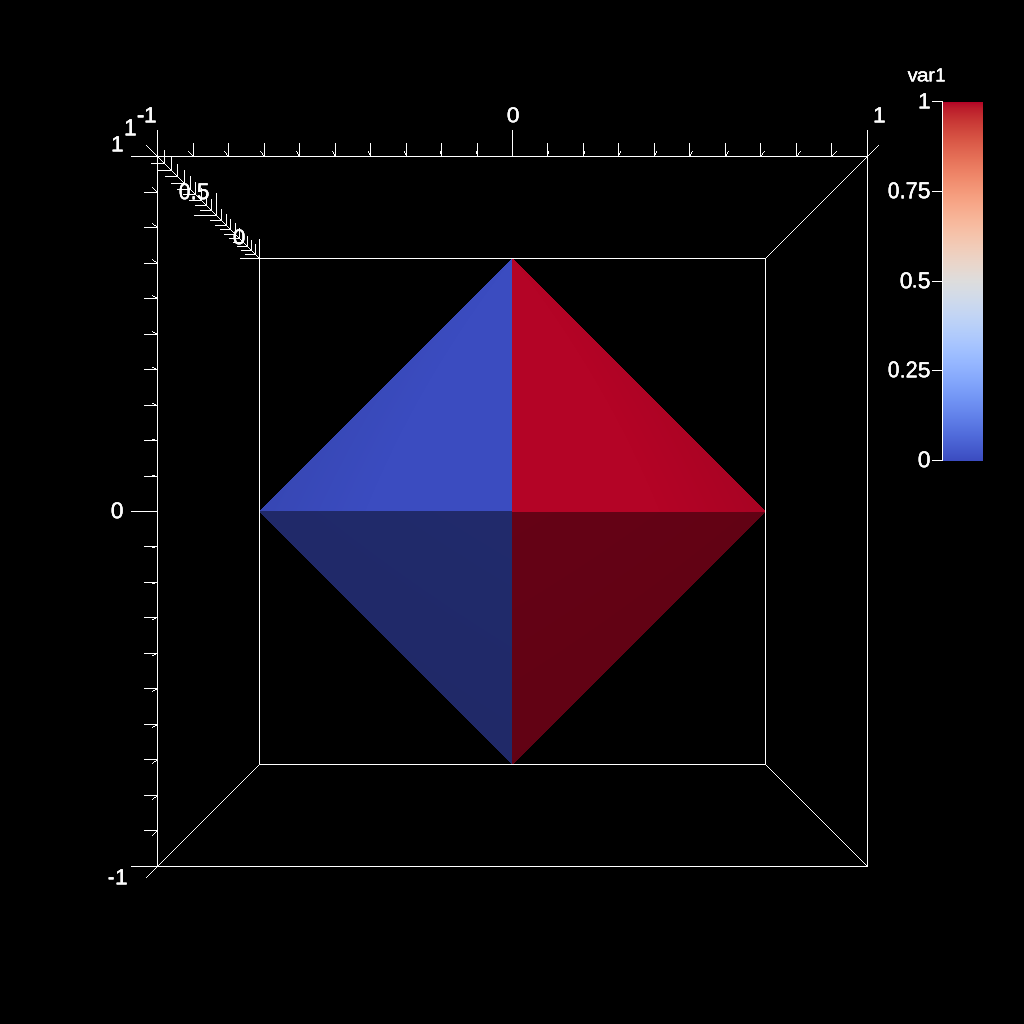

In [15]:
# show the resulting image
Image("out_ascent_render_tet.png",width=img_display_width)